# GDP and Health Expenditure 2018 Comparison

Richer countries can afford to invest more on healthcare, on work and road safety, and other measures that reduce mortality. On the other hand, richer countries may have less healthy lifestyles. Is there any relation between the wealth of a country and the health expenditure of its inhabitants?

The following analysis checks whether there is any correlation between the total gross domestic product (GDP) per capita of a country in 2018 and the health expenditure of people in that country in 2018.

## Getting the data

Two datasets of the World Bank are considered.The datasets were downloaded as Excel files in June 2021.

In [24]:
import warnings
warnings.simplefilter('ignore', FutureWarning)

import pandas as pd

YEAR = 2018
GDP_INDICATOR = 'NY.GDP.PCAP.PP.CD'
gdpReset = pd.read_csv('WB GDPPCCID 2018.csv')

HEALTH_INDICATOR = 'SH.XPD.CHEX.PP.CD'
healthReset = pd.read_csv('WB HEPCID 2018.csv')
healthReset.head()

,Country Name,year,SH.XPD.CHEX.PP.CD
0,Afghanistan,2018,186.407288
1,Albania,2018,697.304871
2,Algeria,2018,962.719360
3,American Samoa,2018,NaN
4,Andorra,2018,3607.000977


## Cleaning the data

Inspecting the data with `head()` and `tail()` shows:

1.  aggregated data, for the Arab World, the Caribbean small states, and other country groups used by the World Bank;
- GDP and life expectancy values are missing for some countries.

The data is therefore cleaned by:
- removing rows with unavailable values.
- filtering data set to ensure the first selected rows are strictly countries

In [25]:
gdpCountries = gdpReset.dropna()
healthCountries = healthReset.dropna()

## Transforming the data

The World Bank reports GDP in US dollars and cents. To make the data easier to read, the GDP is converted to millions of British pounds (the author's local currency) with the following auxiliary functions, using the average 2018 dollar-to-pound conversion rate provided by <http://www.ukforex.co.uk/forex-tools/historical-rate-tools/yearly-average-rates>. 

In [26]:
gdpCountries.head()

,Country Name,year,NY.GDP.PCAP.PP.CD
0,Afghanistan,2018,2156.419482
1,Albania,2018,14224.098070
2,Algeria,2018,12019.928360
5,Angola,2018,6965.511374
6,Antigua and Barbuda,2018,22879.766090


In [27]:
def roundCurrency (value):
    value = float(value)
    return round(value)

def usdToGBP (usd):
    usd = float(usd)
    convert_usd = usd/1.334801
    return convert_usd

GDP = 'GDP (£)'

gdpCountries[GDP] = gdpCountries[GDP_INDICATOR].apply(usdToGBP).apply(roundCurrency)
gdpCountries.head()

<ipython-input-27-f90e61c2471f>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gdpCountries[GDP] = gdpCountries[GDP_INDICATOR].apply(usdToGBP).apply(roundCurrency)


,Country Name,year,NY.GDP.PCAP.PP.CD,GDP (£)
0,Afghanistan,2018,2156.419482,1616
1,Albania,2018,14224.098070,10656
2,Algeria,2018,12019.928360,9005
5,Angola,2018,6965.511374,5218
6,Antigua and Barbuda,2018,22879.766090,17141


The unnecessary columns can be dropped.

In [19]:
COUNTRY = 'Country Name'
headings = [COUNTRY, GDP]
gdpClean = gdpCountries[headings]
gdpClean.head()

,Country Name,GDP (£)
0,Afghanistan,1616
1,Albania,10656
2,Algeria,9005
5,Angola,5218
6,Antigua and Barbuda,17141


The World Bank reports the HEALTH EXPENDITURE with several decimal places. After rounding, the original column is discarded.

In [30]:
HEALTH = 'Health Expenditure (% of GDP)'
healthCountries[HEALTH] = healthCountries[HEALTH_INDICATOR].apply(round)
headings = [COUNTRY, HEALTH]
healthClean = healthCountries[headings]
healthClean.head()

<ipython-input-30-c6b89b00fa89>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  healthCountries[HEALTH] = healthCountries[HEALTH_INDICATOR].apply(round)


,Country Name,Health Expenditure (% of GDP)
0,Afghanistan,186
1,Albania,697
2,Algeria,963
4,Andorra,3607
5,Angola,165


## Combining the data

The tables are combined through an inner join on the common 'country' column. 

In [32]:
gdpVshealth = pd.merge(gdpClean, healthClean, on=COUNTRY, how='inner')
gdpVshealth.head()

,Country Name,GDP (£),Health Expenditure (% of GDP)
0,Afghanistan,1616,186
1,Albania,10656,697
2,Algeria,9005,963
3,Angola,5218,165
4,Antigua and Barbuda,17141,1406


## Calculating the correlation

To measure if the health expenditure and the GDP per capita grow together, the Spearman rank correlation coefficient is used. It is a number from -1 (perfect inverse rank correlation: if one indicator increases, the other decreases) to 1 (perfect direct rank correlation: if one indicator increases, so does the other), with 0 meaning there is no rank correlation. A perfect correlation doesn't imply any cause-effect relation between the two indicators. A p-value below 0.05 means the correlation is statistically significant.

In [33]:
from scipy.stats import spearmanr

gdpColumn = gdpVshealth[GDP]
healthColumn = gdpVshealth[HEALTH]
(correlation, pValue) = spearmanr(gdpColumn, healthColumn)
print('The correlation is', correlation)
if pValue < 0.05:
    print('It is statistically significant.')
else:
    print('It is not statistically significant.')

The correlation is 0.9332715078740859
It is statistically significant.


The value shows a very strong correlation, i.e. richer countries tend to have higher health expenditure

## Showing the data

Measures of correlation can be misleading, so it is best to see the overall picture with a scatterplot. The GDP axis uses a logarithmic scale to better display the vast range of GDP values, from a few million to several billion (million of million) pounds.

<AxesSubplot:xlabel='GDP (£)', ylabel='Health Expenditure (% of GDP)'>

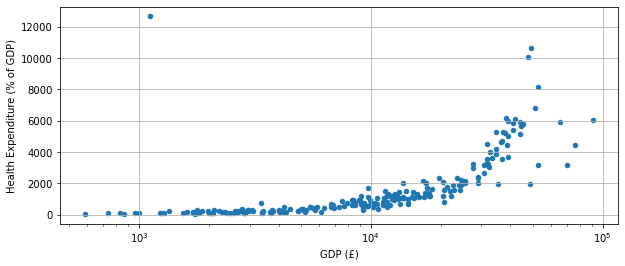

In [36]:
%matplotlib inline
gdpVshealth.plot(x=GDP, y=HEALTH, kind='scatter', grid=True, logx=True, figsize=(10, 4))

The plot shows a very clear and strong correlation: there are rich countries have higher health expenditure

Comparing the 10 poorest countries and the 10 countries with the lowest health expenditure shows that total GDP per capita is a fitting measure. However perhaps population size should be taken into account for a more precise definiton of what 'poor' and 'rich' means. 

In [37]:
# the 10 countries with lowest GDP
gdpVshealth.sort_values(GDP).head(10)

,Country Name,GDP (£),Health Expenditure (% of GDP)
26,Burundi,588,66
31,Central African Republic,739,97
97,Malawi,829,120
37,"Congo, Dem. Rep.",859,31
117,Niger,958,78
109,Mozambique,1002,118
93,Liberia,1117,12643
32,Chad,1236,79
160,Togo,1249,109
96,Madagascar,1289,79


In [38]:
# the 10 countries with lowest health expenditure
gdpVshealth.sort_values(HEALTH).head(10)

,Country Name,GDP (£),Health Expenditure (% of GDP)
37,"Congo, Dem. Rep.",859,31
26,Burundi,588,66
54,Ethiopia,1738,67
117,Niger,958,78
32,Chad,1236,79
96,Madagascar,1289,79
59,"Gambia, The",1739,81
17,Benin,2572,83
100,Mali,1816,90
31,Central African Republic,739,97


## Conclusions

the correlation between a country's wealth and the health expenditure of  of its inhabitants on the basis of the last two diagrams is rather curious: there is a wide variation of health expenditure for countries with similar GDP, countries with the lowest health expenditure are not always the poorest countries, and countries with the highest health expenditure are not the richest countries. Nevertheless there is some relationship.

the usage of  [NY.GDP.PCAP.PP.CD](http://data.worldbank.org/indicator/NY.GDP.PCAP.PP.CD) indicator, GDP per capita in current 'international dollars', was assumed that it would make for a better like-for-like comparison between countries, because it would take population and purchasing power into account. But perhaps gdp per capita may need to be compared to other specific data, beside expediture on health, to possibly  lead to a better analysis.

## TASK HAS BEEN COMPLETED 2018 GDP vs LE COMPARISONS


## THE END!